# Parameter-Matched Recurrent Transformer

## **1. Motivation**

In our main experiments, we compared a **lightweight Recurrent Transformer** against a **standard Transformer** of larger size.
While this comparison demonstrates parameter efficiency, one potential question remains:

> *How much of the performance gap is due to architectural differences, and how much is simply due to model capacity?*

To clarify this, we conduct an ablation experiment where we **scale up the Recurrent Transformer** so that its **parameter count matches** the standard Transformer used in the main study.

This ablation isolates the effect of **architecture** from the effect of **model size**.


## **2. Goal of This Notebook**

This notebook focuses only on training and evaluating a **parameter-matched Recurrent Transformer**.
It is *not* intended to compare against the standard Transformer directly; rather, it serves as a diagnostic study to answer:

* Does the Recurrent Transformer architecture benefit from increased depth or width?
* How does scaling affect stability, convergence speed, and generalization?
* Are the architectural properties still advantageous when the model has comparable capacity to a standard Transformer?


## **3. Why This Matters**

Scaling the recurrent architecture provides insight into:

* **Architecture sensitivity**
  — whether recurrent refinement benefits more from depth or width.

* **Parameter efficiency vs raw capacity**
  — identifying whether performance gains come from structural recurrence or simply from fewer parameters.

* **Model behavior under equal budgets**
  — a fair setting commonly used in architecture studies (e.g., CNN vs Transformer papers).

This ablation strengthens the overall study by showing that the observed trends in the main experiments are not merely artifacts of model size.


## **4. What We Do in This Notebook**

1. Define a **parameter-matched Recurrent Transformer**.
2. Train the model using the same pre-processing, dataloader, and optimization pipeline as the main experiments.
3. Record validation performance, loss curves, and inference time.
4. Analyze how scaling affects the recurrent architecture’s behavior.



In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
RECURRENT_CONFIG = {
    'hidden_size': 384,
    'num_hidden_layers': 6,
    'recurrent_depth': 6,  # Effective depth: 3 × 2 = 6
    'num_attention_heads': 6,
    'intermediate_size': 1536,
    'dropout_prob': 0.1,
    'residual_scale': 0.5,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

TRAINING_CONFIG = {
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 3e-5,
    'warmup_steps': 100,
    'eval_steps': 50,
    'max_length': 128
}

In [4]:
# Load data
from training.utils import prepare_sst2_data, load_tokenizer

tokenizer = load_tokenizer('bert-base-uncased')
train_loader, val_loader, test_loader = prepare_sst2_data(
    data_dir='data/processed',
    tokenizer=tokenizer,
    batch_size=TRAINING_CONFIG['batch_size'],
    max_length=TRAINING_CONFIG['max_length']
)

train_size = len(train_loader) * TRAINING_CONFIG['batch_size']
val_size = len(val_loader) * TRAINING_CONFIG['batch_size']
print(f"Dataset sizes - Train: {train_size}, Validation: {val_size}")


Loaded 63981 samples from data/processed\sst2_train.pkl
Loaded 3368 samples from data/processed\sst2_internal_val.pkl
Loaded 872 samples from data/processed\sst2_val.pkl
Dataset sizes - Train: 63984, Validation: 3376


In [7]:
# Initialize models
from models.recurrent import RecurrentModel, RecurrentConfig

# Recurrent model
recurrent_config = RecurrentConfig(
    vocab_size=30522,
    hidden_size=RECURRENT_CONFIG['hidden_size'],
    num_hidden_layers=RECURRENT_CONFIG['num_hidden_layers'],
    recurrent_depth=RECURRENT_CONFIG['recurrent_depth'],
    num_attention_heads=RECURRENT_CONFIG['num_attention_heads'],
    intermediate_size=RECURRENT_CONFIG['intermediate_size'],
    hidden_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    attention_probs_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    residual_scale=RECURRENT_CONFIG['residual_scale'],
    num_labels=2,
    **{k: v for k, v in RECURRENT_CONFIG.items() if k.startswith('use_')}
)

recurrent_model = RecurrentModel(recurrent_config).to(device)

# Model statistics
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

recurrent_params = count_parameters(recurrent_model)

print(f"Recurrent: {recurrent_params:,} parameters ({recurrent_params/1e6:.1f}M)")



Recurrent: 25,912,706 parameters (25.9M)


In [9]:
# Train both models with early stopping
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import copy
import torch

def train_model(model, name, num_epochs=TRAINING_CONFIG['num_epochs'], patience=3, min_delta=0.001):
    optimizer = AdamW(model.parameters(), lr=TRAINING_CONFIG['learning_rate'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_losses = []

        for batch in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/{num_epochs}", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )

            loss = outputs['loss']
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )

                val_losses.append(outputs['loss'].item())
                predictions = outputs['logits'].argmax(dim=-1)
                val_correct += (predictions == batch['labels']).sum().item()
                val_total += batch['labels'].size(0)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_acc = val_correct / val_total
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0

            print(f"{name} Epoch {epoch+1}: Train_Loss={train_loss:.4f}, Val_Loss={val_loss:.4f}, Acc={val_acc:.4f} *")

            # Save best model at this moment
            save_path = f"{name}_best_model.pt"
            torch.save(best_model_state, save_path)
            # print(f"{name}: Saved new best model → {save_path}")   # Optional log

        else:
            patience_counter += 1
            print(f"{name} Epoch {epoch+1}: Train_Loss={train_loss:.4f}, Val_Loss={val_loss:.4f}, Acc={val_acc:.4f}")

        if patience_counter >= patience:
            print(f"{name}: Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"{name}: Loaded best model with val_loss={best_val_loss:.4f}")

    return history

# Train models
print("Training with early stopping (patience=3)")
recurrent_history = train_model(recurrent_model, "Recurrent")


Training with early stopping (patience=3)


Recurrent Epoch 1: Train_Loss=0.6120, Val_Loss=0.3340, Acc=0.8744 *


Recurrent Epoch 2: Train_Loss=0.3221, Val_Loss=0.2980, Acc=0.8911 *


Recurrent Epoch 3: Train_Loss=0.2511, Val_Loss=0.3194, Acc=0.9057


Recurrent Epoch 4: Train_Loss=0.2154, Val_Loss=0.3192, Acc=0.9099


Recurrent Epoch 5: Train_Loss=0.1886, Val_Loss=0.3273, Acc=0.9135
Recurrent: Early stopping triggered at epoch 5
Recurrent: Loaded best model with val_loss=0.2980


In [10]:
# Evaluate models
def evaluate_model(model, loader):
    model.eval()

    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Measure inference time
            start_time = time.time()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            inference_times.append((time.time() - start_time) * 1000 / batch['input_ids'].size(0))

            predictions = outputs['logits'].argmax(dim=-1)
            total_correct += (predictions == batch['labels']).sum().item()
            total_samples += batch['labels'].size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    accuracy = total_correct / total_samples
    avg_inference_time = np.mean(inference_times)

    # Calculate F1 score
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    return {
    'accuracy': accuracy,
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'inference_time_ms': avg_inference_time,
    'y_true': all_labels,
    'y_pred': all_predictions}

# Evaluate on test set
recurrent_metrics = evaluate_model(recurrent_model, test_loader)

# Model sizes
recurrent_size_mb = recurrent_params * 4 / (1024 * 1024)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Recurrent'],
    'Parameters': [recurrent_params],
    'Size (MB)': [recurrent_size_mb],
    'Accuracy': [recurrent_metrics['accuracy']],
    'F1': [recurrent_metrics['f1']],
    'Precision': [recurrent_metrics['precision']],
    'Recall': [recurrent_metrics['recall']],
    'Inference (ms)': [recurrent_metrics['inference_time_ms']]
})

print(comparison_df.round(4))


       Model  Parameters  Size (MB)  Accuracy      F1  Precision  Recall  \
0  Recurrent    25912706    98.8491     0.893  0.9006     0.9261  0.8765   

   Inference (ms)  
0          1.7279  


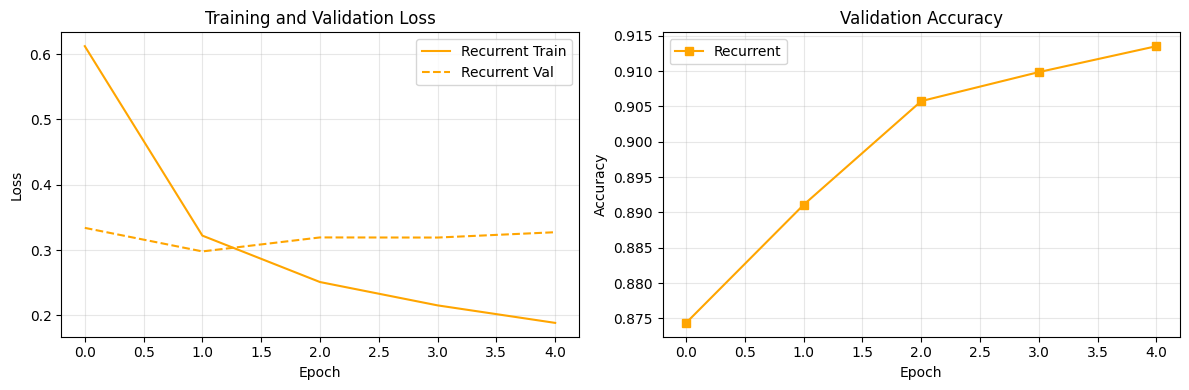

In [11]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(recurrent_history['train_loss'], label='Recurrent Train', color='orange', linestyle='-')
axes[0].plot(recurrent_history['val_loss'], label='Recurrent Val', color='orange', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(recurrent_history['val_acc'], label='Recurrent', color='orange', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


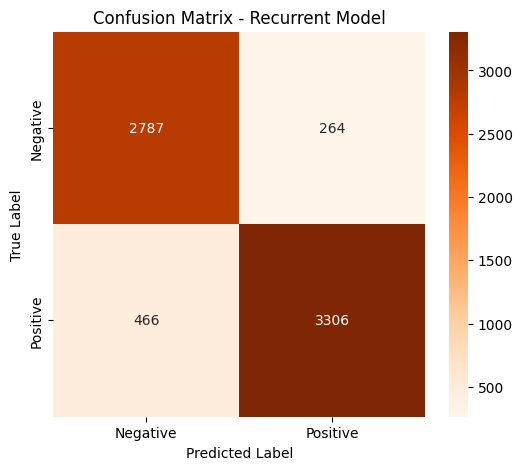

In [13]:
# recurrent model
y_true = recurrent_metrics['y_true']
y_pred = recurrent_metrics['y_pred']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Recurrent Model")
plt.show()
